In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

In [3]:
ads = pd.read_csv('data/AdSmartABdata - AdSmartABdata.csv')

In [4]:
ads.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [9]:
ads.drop('device_make', axis=1, inplace=True)

In [10]:
ads['experiment'] = np.where(ads['experiment'] == 'control', 0, 1)

In [12]:
ads['response'] = ads.yes + ads.no

In [14]:
ads.drop(['yes','no'], axis=1, inplace=True)

In [17]:
ads['date'] = pd.to_datetime(ads.date)

In [21]:
ads['dayofweek'] = ads['date'].apply(lambda x: x.dayofweek)

In [23]:
ads.drop('date', axis=1, inplace=True)

In [25]:
ads['chrome'] = ads['browser'].apply(lambda x: int('Chrome' in x))

In [26]:
ads['facebook'] = ads['browser'].apply(lambda x: int('Facebook' in x))

In [27]:
ads['safari'] = ads['browser'].apply(lambda x: int('Safari' in x))

In [28]:
ads['samsung'] = ads['browser'].apply(lambda x: int('Samsung' in x))

In [30]:
ads.drop(['auction_id','browser'], axis=1, inplace=True)

In [31]:
ads.head()

,experiment,hour,platform_os,response,dayofweek,chrome,facebook,safari,samsung
0,1,8,6,0,4,1,0,0,0
1,1,10,6,0,1,1,0,0,0
2,1,2,6,1,6,1,0,0,0
3,0,15,6,0,4,0,1,0,0
4,0,15,6,0,4,1,0,0,0


In [32]:
y = ads.pop('response')

In [33]:
x = ads

## Frequentist

Does exposure to the SmartAd improve response rate?

### Null Hypothesis: Exposure to the SmartAd does not improve response rate.

### Alternative Hypothesis: Exposure to the SmartAd does improve response rate.

Approach: Use a Binomial test to evaluate whether we can reject the null hypothesis or not.

Threshold: p < 0.05, based on business model specifications

In [42]:
ads['response'] = y

In [43]:
control_response_rate = np.sum(ads[ads['experiment'] == 0]['response'])/len(ads[ads.experiment == 0])

In [44]:
exposure_response_rate = np.sum(ads[ads['experiment'] == 1]['response'])/len(ads[ads.experiment == 1])

In [48]:
num_exposure_responses = np.sum(ads[ads['experiment']==1])['response']

In [45]:
print(control_response_rate)
print(exposure_response_rate)

0.14394497666421027
0.16400399400898652


In [46]:
from scipy.stats import binom

In [47]:
null_dist = binom(n = len(ads[ads.experiment==1]), p = control_response_rate)

In [51]:
p_value = 1 - null_dist.cdf(num_exposure_responses)
print(f"The P-Value is: {p_value}")

The P-Value is: 0.00017325902905451773


### Visualizing the data

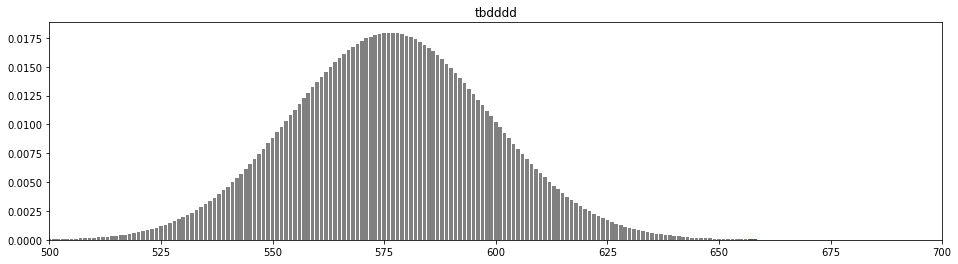

In [52]:
fig, ax = plt.subplots(1, figsize=(16, 4))
bars = ax.bar(range(675), [null_dist.pmf(i) for i in range(675)], align="center", color="grey")
ax.set_xlim(500, 700)
ax.set_title("tbdddd")
for i in range(num_exposure_responses,675):
    bars[i].set_color('red')

## What if our client wanted to see a 1% lift from the SmartAd?

We could raise our threshold on the binomial distribution and run the same test!

### Null Hypothesis: Exposure to the SmartAd does not improve response rate.

### Alternative Hypothesis: Exposure to the SmartAd does improve response rate.

Approach: Use a Binomial test to evaluate whether we can reject the null hypothesis or not.

Threshold: p < 0.05, based on business model specifications

In [57]:
control_response_rate = (np.sum(ads[ads['experiment'] == 0]['response'])/len(ads[ads.experiment == 0])) + 0.01

In [58]:
null_dist_lift = binom(n = len(ads[ads.experiment==1]), p = control_response_rate)

In [60]:
p_value = 1 - null_dist_lift.cdf(num_exposure_responses)
print(f"The P-Value is: {p_value}")

The P-Value is: 0.03792092332560393


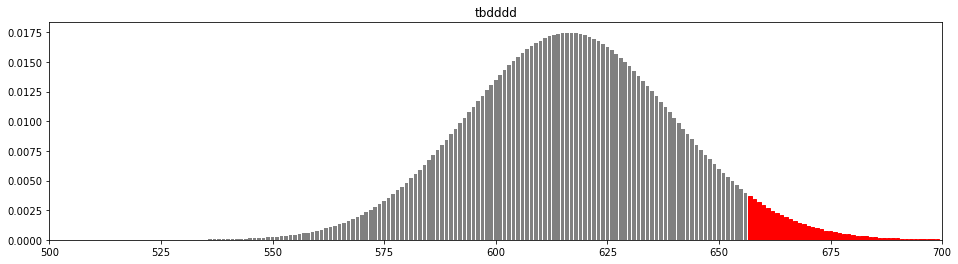

In [63]:
fig, ax = plt.subplots(1, figsize=(16, 4))
bars = ax.bar(range(700), [null_dist_lift.pmf(i) for i in range(700)], align="center", color="grey")
ax.set_xlim(500, 700)
ax.set_title("tbdddd")
for i in range(num_exposure_responses,700):
    bars[i].set_color('red')

## Bayesian Method

In [64]:
ads.head()

,experiment,hour,platform_os,dayofweek,chrome,facebook,safari,samsung,response
0,1,8,6,4,1,0,0,0,0
1,1,10,6,1,1,0,0,0,0
2,1,2,6,6,1,0,0,0,1
3,0,15,6,4,0,1,0,0,0
4,0,15,6,4,1,0,0,0,0


In [75]:
ctrl_alpha = len(ads[(ads['experiment'] == 0) & (ads['response'] == 1)])
ctrl_beta = len(ads[(ads['experiment'] == 0) & (ads['response'] == 0)])

In [77]:
exp_alpha = len(ads[(ads['experiment'] == 1) & (ads['response'] == 1)])
exp_beta = len(ads[(ads['experiment'] == 1) & (ads['response'] == 0)])

In [80]:
from scipy.stats import beta

In [81]:
ctrl_dist = beta(ctrl_alpha, ctrl_beta)
exp_dist = beta(exp_alpha, exp_beta)

In [83]:
ctrl_cred_int_low, ctrl_cred_int_high = ctrl_dist.ppf([0.025, 0.975])
exp_cred_int_low, exp_cred_int_high = exp_dist.ppf([0.025, 0.975])

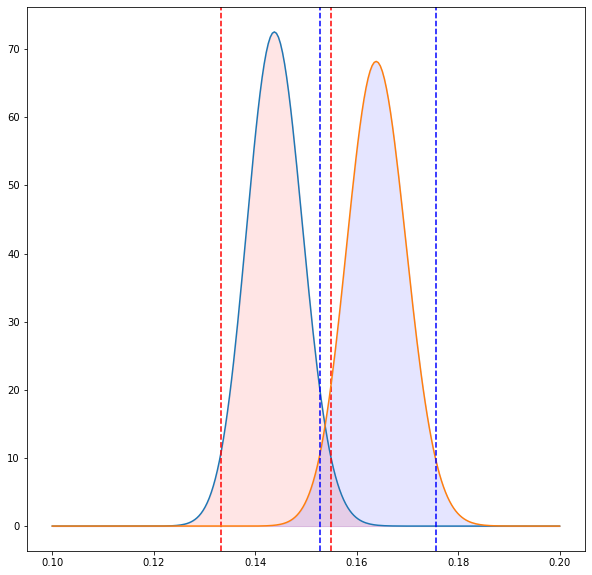

In [87]:
x = np.linspace(0.1, 0.2, 250)

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(x, ctrl_dist.pdf(x))
ax.fill_between(x, 0, ctrl_dist.pdf(x), color='r', alpha=0.1)
ax.axvline(x = ctrl_cred_int_low, linestyle='dashed', color = 'r', label='95% credible interval')
ax.axvline(x = ctrl_cred_int_high, linestyle='dashed', color = 'r')

ax.plot(x, exp_dist.pdf(x))
ax.fill_between(x, 0, exp_dist.pdf(x), color= 'b', alpha=0.1)
ax.axvline(x = exp_cred_int_low, linestyle='dashed', color= 'b', label = '95% credible interval')
ax.axvline(x = exp_cred_int_high, linestyle='dashed', color= 'b')

In [88]:
num_simulations = 10000000

simulated_A = ctrl_dist.rvs(num_simulations)
simulated_B = exp_dist.rvs(num_simulations)
C_vs_A = simulated_B > simulated_A
print((simulated_B > simulated_A).mean())

0.9937975


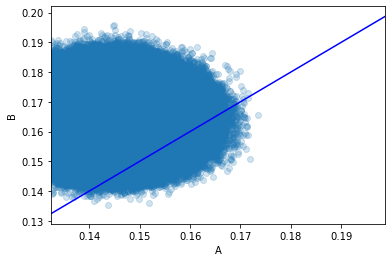

In [89]:
plt.scatter(simulated_A, simulated_B, alpha = .2);
plt.xlim(plt.ylim())
plt.xlabel('A'), plt.ylabel('B')
plt.plot(plt.xlim(), plt.xlim(), color = 'blue');

## But what if we want that 1% lift again?

In [90]:
print((simulated_B > simulated_A + 0.01).mean())

0.8948475


## 2%?

In [91]:
print((simulated_B > simulated_A + 0.02).mean())

0.502843


## Machine Learning

In [40]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, stratify=y)

In [37]:
elastic_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1])

In [41]:
elastic_model.fit(x_train, y_train)

/home/rasputin1127/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.43575276312583355, tolerance: 0.08410769230769233
  positive)


ElasticNetCV(l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1])

In [ ]:
elastic_m